In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import math

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, roc_curve
from sklearn import utils, svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB

In [2]:
warnings.filterwarnings('ignore') # ignore warnings

In [3]:
df_raw = pd.read_csv('SentimentLabeled_10112022.csv')
df = df_raw.drop_duplicates()

# remove {} from columns
df['term_partisanship'] = df['term_partisanship'].str.strip('{}')
df['term_type'] = df['term_type'].str.strip('{}')
df['term_state'] = df['term_type'].str.strip('{}')

# Clean bucket column
df['Bucket'] = df['Bucket'].replace({'1.0':'1', '2.0':'2', '3.0':'3'})

# filter out rows with abonormal sentiment score
df = df[(df['SentimentScore'] <= 5) | (df['SentimentScore'].isnull())]

df.head()

,date,text,userid_str,status_id_str,id,name,birth,term_partisanship,term_type,term_state,country,Bucket,SentimentScore,version
0,2015-09-28,I commend all of law enforcement for the secur...,156333623.0,6.485341e+17,3517566,Al Green,1947-09-01,Democrat,rep,rep,China,2 or 3,NaN,2019_batch1
1,2019-02-24,"Socialist tyrant Maduro starves, tortures his ...",235312723.0,1.099734e+18,3559992,Scott DesJarlais,1964-02-21,Republican,rep,rep,China,1,2.0,2019_batch1
2,2019-02-24,"Socialist tyrant Maduro starves, tortures his ...",235312723.0,1.099734e+18,3559992,Scott DesJarlais,1964-02-21,Republican,rep,rep,Iran,2 or 3,NaN,2019_batch1
3,2014-06-24,Inhofe: The Canadians have already had convers...,20546536.0,4.815273e+17,3468157,James M. Inhofe,1934-11-17,Republican,sen,sen,Canada,2 or 3,NaN,2019_batch1
4,2015-07-14,Statement on Iran nuclear agreement. http://t....,18773159.0,6.210401e+17,3833428,Scott Perry,1962-05-27,Republican,rep,rep,Iran,2 or 3,NaN,2019_batch1


## Feature Engineering 1 (Doc2Vec)

In [4]:
feats1 = df[df['country'] == 'China'][['text']]
feats1['Bucket_1'] = (df['Bucket'] == '1') # target column: boolean value of whether a tweet belongs to bucket 1
# texts['num_word'] = texts['text'].str.split().apply(len) # number of words in a tweet

In [5]:
(feats1['Bucket_1'] == 1).mean()

0.7358203916272789

In [6]:
text_tokenized = feats1['text'].apply(word_tokenize) #tokenize each tweet
tagged_text = [TaggedDocument(d,[i]) for i, d in enumerate(text_tokenized)] #tag sentence corpus
d2v_model = Doc2Vec(tagged_text, vector_size=30, window=2, min_count=1, epochs=100) #train Doc2Vec model

In [7]:
feats1['text_vector'] = text_tokenized.apply(d2v_model.infer_vector) # convert text to vectors of length 20

In [8]:
feats1['text_vector'] = feats1['text_vector'].apply(lambda x: list(x))
feats1[list(range(1,31))] = pd.DataFrame(feats1['text_vector'].tolist(), index= feats1.index)

In [9]:
feats1 = feats1.drop(['text_vector'], axis = 1)

## SVM

In [10]:
training, testing = train_test_split(feats1, test_size=0.25, random_state=25)
train_y = training['Bucket_1']
train_X = training.drop(['text', 'Bucket_1'], axis = 1)
test_y = testing['Bucket_1']
test_X = testing.drop(['text', 'Bucket_1'], axis = 1)

In [41]:
svc = svm.SVC(C=10, gamma=0.01, kernel='rbf', probability=True).fit(train_X, train_y)

In [42]:
svc.score(train_X, train_y)

0.8158901643033986

In [43]:
y_pred = svc.predict(test_X)
tn, fp, fn, tp = confusion_matrix(test_y, y_pred).ravel()
accuracy = (tn + tp)/(tn + fp + fn + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
print(accuracy, precision, recall, f1)

0.7741390952059419 0.7897301349325337 0.9512415349887133 0.8629940610280566


In [14]:
def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= confusion_matrix(y, pred, 
            normalize='true')
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0', 'True 1'], 
            columns=['Pred 0', 'Pred 1'])

In [15]:
conf_matrix(test_y, y_pred)

,Pred 0,Pred 1
True 0,TN = 38 (TNR = 4.19%),FP = 870 (FPR = 95.81%)
True 1,FN = 56 (FNR = 2.12%),TP = 2591 (TPR = 97.88%)


In [33]:
print(grid_svm.best_params_)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [16]:
prob_test=svm_tuned.predict_proba(test_X)[:,1]

In [17]:
fpr, tpr, thresholds = roc_curve(test_y, y_pred)

In [19]:
ypred_thres = np.where(prob_test >= 0.732, True, False)
conf_matrix(test_y, ypred_thres)

,Pred 0,Pred 1
True 0,TN = 46 (TNR = 5.07%),FP = 862 (FPR = 94.93%)
True 1,FN = 66 (FNR = 2.49%),TP = 2581 (TPR = 97.51%)


In [20]:
tn, fp, fn, tp = confusion_matrix(test_y, ypred_thres).ravel()
accuracy = (tn + tp)/(tn + fp + fn + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
print(accuracy, precision, recall, f1)

0.7389592123769338 0.7496369445251234 0.9750661125802795 0.8476190476190476


In [17]:
###### with tfidf
train_X1 = training[['text']].str.lower()
test_X1 = testing[['text']].str.lower()

stopword = stopwords.words('english')
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stopword)),
    ('svm', svm.SVC(C=100, gamma=0.01, kernel='rbf', probability=True))])
pipe.fit(train_X1, train_y)

ValueError: Found input variables with inconsistent numbers of samples: [1, 8886]

In [15]:
train_X.shape

(8886, 30)

In [16]:
train_X

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
15301,-1.289430,-1.209546,2.042649,0.656167,1.120668,-1.517295,0.283924,-0.829098,-1.376278,-0.041185,...,-1.120096,-0.401588,1.195674,1.496003,0.613466,1.727026,-0.316908,2.717289,1.144872,-0.523642
7502,0.808763,0.393784,2.316195,-1.311673,-0.700674,0.810254,-0.174422,-0.908529,0.385117,0.849195,...,0.046759,-1.373943,0.664910,0.202147,0.359298,-0.078059,-0.127443,1.105441,2.317849,0.557104
851,0.533613,1.874624,1.110867,-0.231000,1.450825,1.876877,2.073741,-0.299521,1.309019,0.271638,...,1.082002,-1.426180,0.698518,1.242439,0.602408,0.188484,3.052398,-1.221592,1.548343,-1.869006
11359,1.139268,-0.484377,0.574848,1.254545,0.245701,-0.397150,1.858872,1.508130,-1.599751,-0.925676,...,0.598752,1.678811,-0.596155,3.304334,-1.091448,0.513954,0.544940,1.432108,-0.148844,-0.535941
6692,-0.093004,1.071921,0.406782,-1.885284,-2.129166,-0.543953,0.750004,2.597677,-1.581244,-0.325343,...,-1.675036,0.453804,0.896041,1.003501,-0.171556,-0.029186,0.100842,-0.581907,1.349542,-1.471108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11456,-1.628552,1.097441,1.320582,-0.274499,1.867674,-0.198036,0.347062,-0.715710,-1.024468,-1.058419,...,-0.055328,-0.478897,2.086361,2.363447,2.862122,-0.293090,-1.252920,0.472277,1.271678,0.050946
4711,-0.750244,0.260214,2.339224,-1.446182,0.166708,-0.298965,0.978298,-0.555668,0.551771,-0.888808,...,0.565831,-0.984204,-0.266516,1.577443,-0.138594,0.538887,0.848096,-1.254274,-0.575468,-0.955296
13854,0.887187,-0.406905,-0.195875,0.386963,0.229973,-1.151680,-0.895380,-0.978840,-0.766788,0.221061,...,-0.272770,-1.673250,-0.154956,0.846480,2.101977,-0.092535,-0.931773,1.669484,2.674504,-0.213896
9515,0.355341,0.559144,2.583841,-1.259426,0.212009,0.100969,1.249847,-1.415061,-0.483466,1.382175,...,-0.612853,-0.564931,2.287817,0.405738,0.701197,-1.446544,0.588175,0.689233,2.104477,-1.085895


In [50]:
y_pred1 = pipe.predict(test_X1)
tn, fp, fn, tp = confusion_matrix(test_y, y_pred1).ravel()
accuracy = (tn + tp)/(tn + fp + fn + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
print(accuracy, precision, recall, f1)

0.7734638757596218 0.8128038897893031 0.9056433408577879 0.8567157804825966


In [39]:
conf_matrix(test_y, y_pred1)

,Pred 0,Pred 1
True 0,TN = 361 (TNR = 39.76%),FP = 547 (FPR = 60.24%)
True 1,FN = 248 (FNR = 9.37%),TP = 2399 (TPR = 90.63%)


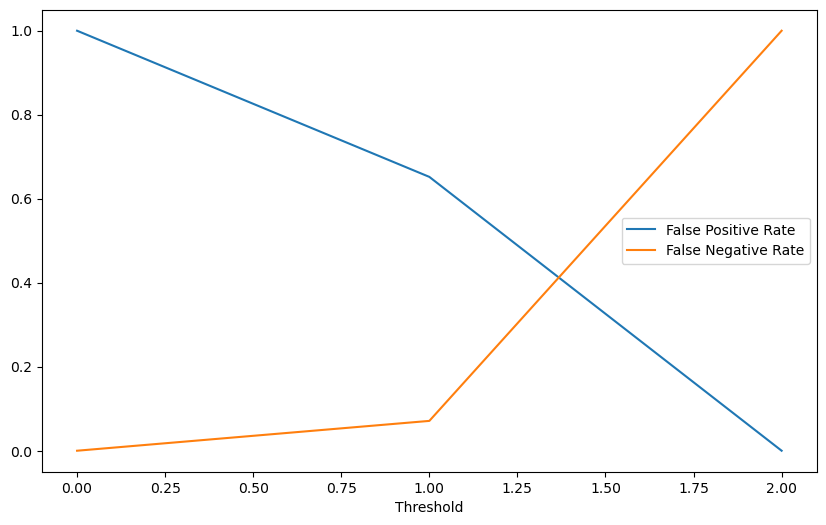

In [24]:
prob_test1=pipe.predict_proba(test_X1)[:,1]
fpr, tpr, thresholds = roc_curve(test_y, y_pred1)
dfplot=pd.DataFrame({'Threshold':thresholds, 
        'False Positive Rate':fpr, 
        'False Negative Rate': 1.-tpr})
ax=dfplot.plot(x='Threshold', y=['False Positive Rate',
        'False Negative Rate'], figsize=(10,6))

In [25]:
ypred_thres = np.where(prob_test1 >= 0.76, True, False)
conf_matrix(test_y, ypred_thres)

,Pred 0,Pred 1
True 0,TN = 631 (TNR = 69.49%),FP = 277 (FPR = 30.51%)
True 1,FN = 820 (FNR = 30.98%),TP = 1827 (TPR = 69.02%)


In [26]:
tn, fp, fn, tp = confusion_matrix(test_y, ypred_thres).ravel()
accuracy = (tn + tp)/(tn + fp + fn + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
print(accuracy, precision, recall, f1)

0.6914205344585092 0.8683460076045627 0.6902153381186249 0.7691012418438224


## Naive Bayes

In [55]:
nb = BernoulliNB().fit(train_X, train_y)

In [56]:
ypred_nb = nb.predict(test_X)
tn, fp, fn, tp = confusion_matrix(test_y, ypred_nb).ravel()
accuracy = (tn + tp)/(tn + fp + fn + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
print(accuracy, precision, recall, f1)

0.7535449020931803 0.7722772277227723 0.9507900677200903 0.8522865236746258


In [57]:
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stopword)),
    ('nb', BernoulliNB())])
pipe_nb.fit(train_X1, train_y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('nb', BernoulliNB())])

In [59]:
ypred_nb1 = pipe_nb.predict(test_X1)
tn, fp, fn, tp = confusion_matrix(test_y, ypred_nb1).ravel()
accuracy = (tn + tp)/(tn + fp + fn + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
print(accuracy, precision, recall, f1)

0.787643484132343 0.7941394658753709 0.9665914221218962 0.8719201791895744


## Decision Tree

In [60]:
dt=DecisionTreeClassifier().fit(train_X, train_y)

In [61]:
ypred_dt = dt.predict(test_X)
tn, fp, fn, tp = confusion_matrix(test_y, ypred_dt).ravel()
accuracy = (tn + tp)/(tn + fp + fn + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
print(accuracy, precision, recall, f1)

0.6580013504388926 0.7826904985888994 0.7512415349887133 0.7666436304998847


In [62]:
# # GridSearch
# dt_param = {
#     'criterion':['gini','entropy'],
#     'max_depth':[15, 20, 25, 30, 35],
#     'min_samples_leaf': range(1,6)
# }
# dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_param, verbose = 3)
# dt_grid.fit(train_X, train_y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END criterion=gini, max_depth=15, min_samples_leaf=1;, score=0.672 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=15, min_samples_leaf=1;, score=0.671 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=15, min_samples_leaf=1;, score=0.657 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=15, min_samples_leaf=1;, score=0.664 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=15, min_samples_leaf=1;, score=0.673 total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=15, min_samples_leaf=2;, score=0.661 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=15, min_samples_leaf=2;, score=0.651 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=15, min_samples_leaf=2;, score=0.652 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=15, min_samples_leaf=2;, score=0.656 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=15, min_samples_leaf=2;, score=0.672 total t

[CV 3/5] END criterion=gini, max_depth=30, min_samples_leaf=3;, score=0.644 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=30, min_samples_leaf=3;, score=0.653 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=30, min_samples_leaf=3;, score=0.648 total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=30, min_samples_leaf=4;, score=0.607 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=30, min_samples_leaf=4;, score=0.645 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=30, min_samples_leaf=4;, score=0.634 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=30, min_samples_leaf=4;, score=0.645 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=30, min_samples_leaf=4;, score=0.655 total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=30, min_samples_leaf=5;, score=0.648 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=30, min_samples_leaf=5;, score=0.652 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=30, min_sam

[CV 3/5] END criterion=entropy, max_depth=20, min_samples_leaf=5;, score=0.661 total time=   0.2s
[CV 4/5] END criterion=entropy, max_depth=20, min_samples_leaf=5;, score=0.675 total time=   0.2s
[CV 5/5] END criterion=entropy, max_depth=20, min_samples_leaf=5;, score=0.654 total time=   0.3s
[CV 1/5] END criterion=entropy, max_depth=25, min_samples_leaf=1;, score=0.637 total time=   0.3s
[CV 2/5] END criterion=entropy, max_depth=25, min_samples_leaf=1;, score=0.652 total time=   0.3s
[CV 3/5] END criterion=entropy, max_depth=25, min_samples_leaf=1;, score=0.664 total time=   0.3s
[CV 4/5] END criterion=entropy, max_depth=25, min_samples_leaf=1;, score=0.669 total time=   0.3s
[CV 5/5] END criterion=entropy, max_depth=25, min_samples_leaf=1;, score=0.657 total time=   0.3s
[CV 1/5] END criterion=entropy, max_depth=25, min_samples_leaf=2;, score=0.636 total time=   0.3s
[CV 2/5] END criterion=entropy, max_depth=25, min_samples_leaf=2;, score=0.652 total time=   0.2s
[CV 3/5] END criteri

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [15, 20, 25, 30, 35],
                         'min_samples_leaf': range(1, 6)},
             verbose=3)

In [63]:
# print(dt_grid.best_params_)

{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 3}


In [66]:
dt_tuned=DecisionTreeClassifier(
    criterion='entropy',
    max_depth=15,
    min_samples_leaf=3).fit(train_X, train_y)

ypred_dt1 = dt_tuned.predict(test_X)
tn, fp, fn, tp = confusion_matrix(test_y, ypred_dt1).ravel()
accuracy = (tn + tp)/(tn + fp + fn + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
print(accuracy, precision, recall, f1)

0.6887238352464551 0.7821911828895679 0.8090293453724605 0.7953839325343987


In [67]:
pipe_dt = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stopword)),
    ('dt', DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=3))])
pipe_dt.fit(train_X1, train_y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('dt',
                 DecisionTreeClassifier(criterion='entropy', max_depth=15,
                                        min_samples_leaf=3))])

In [68]:
ypred_dt2 = pipe_dt.predict(test_X1)
tn, fp, fn, tp = confusion_matrix(test_y, ypred_dt2).ravel()
accuracy = (tn + tp)/(tn + fp + fn + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
print(accuracy, precision, recall, f1)

0.7390276839972991 0.781640625 0.9033860045146727 0.8381151832460733
